# MLT-01 Logistic Regression Model Building

- Authored by: *Jay Parmar*
- Last modified on: *12th August 2023*

## Approach

1. Define a Classification Task
2. Read the Dataset
3. Generate Target Values
4. Feature Selection
5. Feature Extraction
6. Generate Train-Test Datasets
7. Feature Scaling
8. Build Model
9. Train Model
10. Predict
11. Evaluate

### 1. Classification Task

*To predict whether the next day is going to be an UP day or not*

In [1]:
# Importing necessary library
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
%matplotlib inline

warnings.filterwarnings('ignore')

# Set the seaborn visualization style
sns.set()

### 2. Read the dataset

In [3]:
# Read the dataset
df = pd.read_csv('MLT01_data_TSLA.csv', index_col='Date')

In [4]:
# Make the copy of the data. We will work on the copied data.
data = df.copy()

In [5]:
# Inspect the data
data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2013-12-31,152.320007,153.199997,148.660004,150.429993,150.429993,4262400
2014-01-02,149.800003,152.479996,146.550003,150.100006,150.100006,6188400
2014-01-03,150.000000,152.190002,148.600006,149.559998,149.559998,4695000
2014-01-06,150.000000,150.399994,145.240005,147.000000,147.000000,5361100
2014-01-07,147.619995,150.399994,145.250000,149.360001,149.360001,5034100


In [6]:
# Check the shape of the data
data.shape

(1510, 6)

### 3. Generate Target Values

Let's say we want to predict the next days movement: up or down. What kind of ML problem would it be? It would be a classification task. And for that purpose, we need to create our target values. Let's create it.

In [7]:
# Generate log returns
data['returns'] = np.log(data['Close'] / data['Close'].shift(1))

If the next day is up day, we will designate it with 1, else if it is a down day, we will mark it with -1.

In [8]:
# Create target values
data['target'] = np.where(data.returns.shift(-1) > 0, 1, 0)

In [9]:
# Count the values in the target column
data['target'].value_counts()

1    761
0    749
Name: target, dtype: int64

In [10]:
features = ['Volume', 'returns']
label = 'target'

### 4. Feature Selection

We have OHLCV data with us. These OHCLV columns are our features. Based on this data, we will try to predict the next day's movement. But let's first understand which of these features can actually be used. Our intuition says that Close price plays the major role in the determining the next days movement. So we'll be considering it. What about other features.

To decide on what features to use and which one to ignore, let's analyze their relationship, starting with the Volume column.

In [11]:
data['target'].value_counts()

1    761
0    749
Name: target, dtype: int64

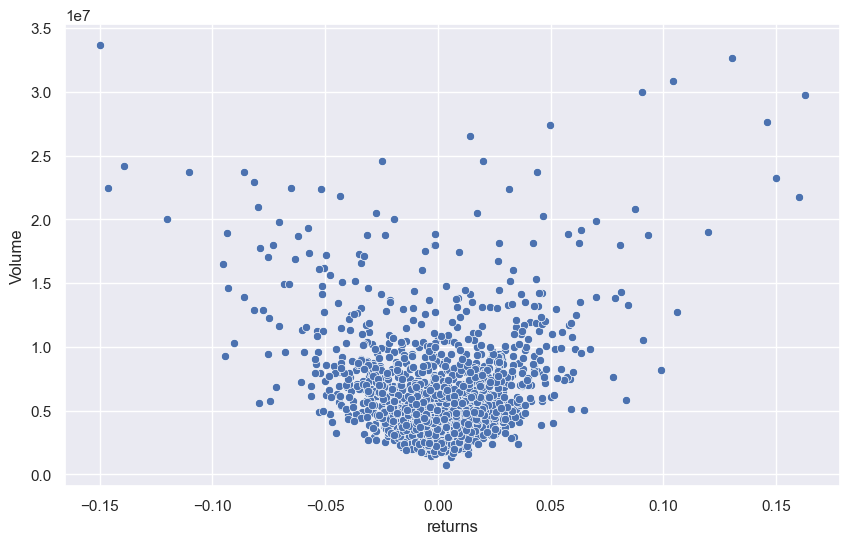

In [12]:
# Scatter plot of Close and Volume
plt.figure(figsize=(10,6))
sns.scatterplot(x=data['returns'], y=data['Volume']);

### 5. Feature Extraction

Our intuition says that only these two features might not be able to capture the intricacies of the stock movement. We need more features. What we can do to generate more features? The answer is, create or extract new features based on the existing ones.

Let's try to create new features. We will consider the following quantitative features.

- Rolling standard deviation
- Rolling moving average of close price
- Rolling percentage change
- Rolling moving average of volume
- Difference between close and open

In [13]:
# Creating features
features_list = []

# SD based features
for i in range(5, 20, 5):
    col_name = 'std_' + str(i)
    data[col_name] = data['Close'].rolling(window=i).std()
    features_list.append(col_name)
    
# MA based features
for i in range(10, 30, 5):
    col_name = 'ma_' + str(i)
    data[col_name] = data['Close'].rolling(window=i).mean()
    features_list.append(col_name)
    
# Daily pct change based features
for i in range(3, 12, 3):
    col_name = 'pct_' + str(i)
    data[col_name] = data['Close'].pct_change().rolling(i).sum()
    features_list.append(col_name)
    
# Feature based on volume
col_name = 'vma_4'
data[col_name] = data['Volume'].rolling(4).mean()
features_list.append(col_name)

# Intraday movement
col_name = 'co'
data[col_name] = data['Close'] - data['Open']
features_list.append(col_name)

This process of extracting information from the existing features is called feature extraction. We now have a handful of features as shown below. 

In [14]:
features_list

['std_5',
 'std_10',
 'std_15',
 'ma_10',
 'ma_15',
 'ma_20',
 'ma_25',
 'pct_3',
 'pct_6',
 'pct_9',
 'vma_4',
 'co']

We'll be using these features to predict the next days movement. We won't be using the `Close` and `Volume` columns. Now, is the time to generate our train and test data. Onwards to it.

As we are dealing with time-series data, we need to split our data set in such a way that it doesn't have a lookahead bias. But before we do it, can you think of any potential issue. Again, resorting to our old friend `.info()` will help us see for any potential issues.

In [15]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1510 entries, 2013-12-31 to 2019-12-30
Data columns (total 20 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       1510 non-null   float64
 1   High       1510 non-null   float64
 2   Low        1510 non-null   float64
 3   Close      1510 non-null   float64
 4   Adj Close  1510 non-null   float64
 5   Volume     1510 non-null   int64  
 6   returns    1509 non-null   float64
 7   target     1510 non-null   int32  
 8   std_5      1506 non-null   float64
 9   std_10     1501 non-null   float64
 10  std_15     1496 non-null   float64
 11  ma_10      1501 non-null   float64
 12  ma_15      1496 non-null   float64
 13  ma_20      1491 non-null   float64
 14  ma_25      1486 non-null   float64
 15  pct_3      1507 non-null   float64
 16  pct_6      1504 non-null   float64
 17  pct_9      1501 non-null   float64
 18  vma_4      1507 non-null   float64
 19  co         1510 non-null   float64
dty

In [16]:
data.isna().sum()

Open          0
High          0
Low           0
Close         0
Adj Close     0
Volume        0
returns       1
target        0
std_5         4
std_10        9
std_15       14
ma_10         9
ma_15        14
ma_20        19
ma_25        24
pct_3         3
pct_6         6
pct_9         9
vma_4         3
co            0
dtype: int64

Yes, there is an issue. There are many null values in many features. We need to get rid of them before we move further.

In [17]:
# Removing nan values
data.dropna(inplace=True)

In [18]:
data[features_list + ['target']].head()

,std_5,std_10,std_15,ma_10,ma_15,ma_20,ma_25,pct_3,pct_6,pct_9,vma_4,co,target
Date,,,,,,,,,,,,,
2014-02-05,3.358835,4.044919,5.163403,177.384000,175.612666,168.966499,165.031199,-0.038671,-0.020722,-0.035616,6307000.0,-3.880005,1
2014-02-06,2.545262,3.805397,4.101563,177.072000,176.562666,170.321500,166.149200,0.007736,0.019641,0.025104,6140200.0,2.080002,1
2014-02-07,4.519428,4.707440,4.531228,178.264999,177.599999,172.271500,167.606400,0.044278,0.021901,0.099315,6681100.0,5.520004,1
2014-02-10,8.796296,6.556036,6.223964,180.959000,179.369999,174.813499,169.486400,0.122164,0.083493,0.101442,8752200.0,7.220001,1
2014-02-11,10.191657,8.111585,7.588278,182.782999,180.699333,177.677499,171.471199,0.099766,0.107502,0.119406,9612675.0,-2.350006,0


In [19]:
# sns.pairplot(data[features_list+['target']], hue='target')

### 6. Generate Training & Testing Datasets

In [20]:
from sklearn.model_selection import train_test_split

In [21]:
X_train , X_test, y_train, y_test = train_test_split(data[features_list].iloc[:-1],
                                                    data.iloc[:-1]['target'],
                                                    test_size= 0.25, 
                                                    shuffle=False)

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((1113, 12), (1113,), (372, 12), (372,))

### 7. Feature Scaling

Now, we are almost ready to train our model and start predicting. But many ML algorithms requires normalized data. So, we need to make sure that the data we feed to our model is normalized. For that purpose, let's start by analyzing the data distribution of the features.

In [22]:
X_train.columns

Index(['std_5', 'std_10', 'std_15', 'ma_10', 'ma_15', 'ma_20', 'ma_25',
       'pct_3', 'pct_6', 'pct_9', 'vma_4', 'co'],
      dtype='object')

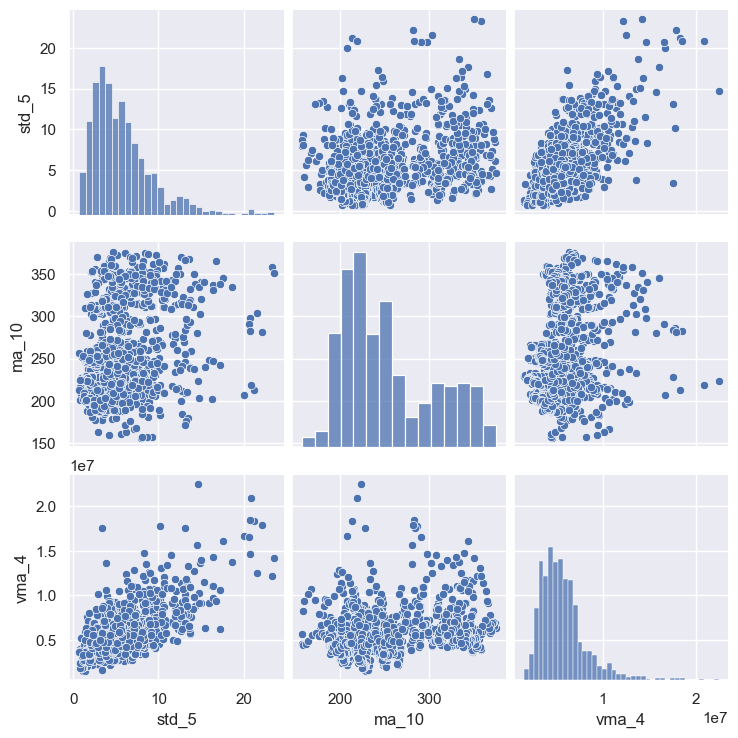

In [23]:
sns.pairplot(X_train[['std_5', 'ma_10', 'vma_4']])

From the above plot we can see that features have different distribution and their scales are different. Hence, it won't be a good idea to feed these data as it is to the ML algorithm. We need to scale the data. We can use `StandardScaler` package from the `sklearn` library to do so.

In [24]:
from sklearn.preprocessing import StandardScaler

In [25]:
# Scaling the features
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

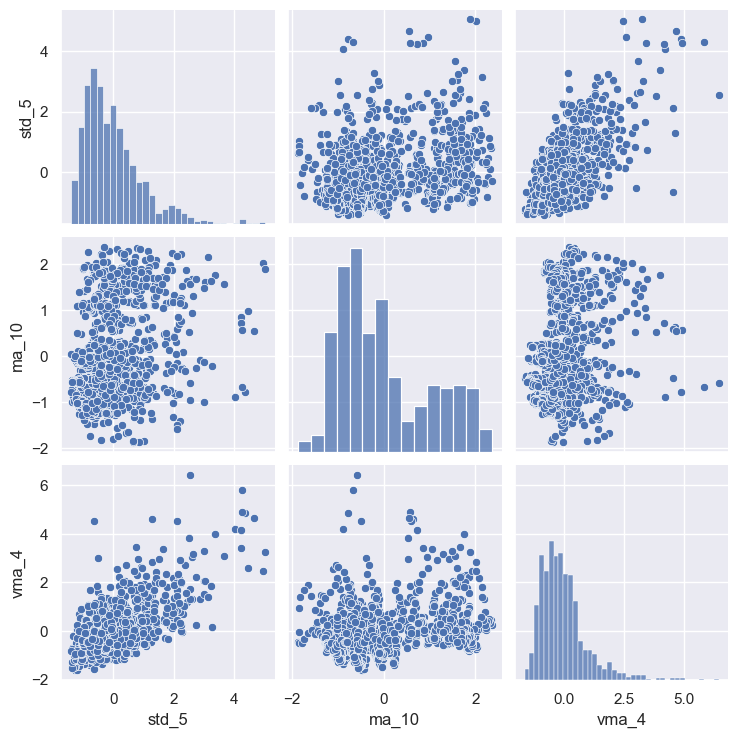

In [26]:
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns)

sns.pairplot(X_train_scaled_df[['std_5', 'ma_10', 'vma_4']])

From the above plot, we can see that values are now scaled with mean 0 and std 1. Another, interesting thing to note about `StandardScaler` is that is just scales the values, it doesn't change the data distribution.

Likewise, all features will now have mean 0 and std 1. 

In [27]:
X_train_scaled_df.describe().T.round(2)

,count,mean,std,min,25%,50%,75%,max
std_5,1113.0,-0.0,1.0,-1.40,-0.71,-0.23,0.43,5.04
std_10,1113.0,0.0,1.0,-1.67,-0.70,-0.23,0.53,4.42
std_15,1113.0,0.0,1.0,-1.68,-0.71,-0.19,0.51,4.27
ma_10,1113.0,-0.0,1.0,-1.88,-0.79,-0.27,0.77,2.36
ma_15,1113.0,-0.0,1.0,-1.75,-0.77,-0.26,0.75,2.30
ma_20,1113.0,0.0,1.0,-1.64,-0.76,-0.27,0.77,2.25
ma_25,1113.0,-0.0,1.0,-1.72,-0.75,-0.30,0.78,2.17
pct_3,1113.0,0.0,1.0,-4.07,-0.57,-0.00,0.61,4.25
pct_6,1113.0,0.0,1.0,-4.29,-0.65,0.02,0.65,4.22
pct_9,1113.0,0.0,1.0,-3.48,-0.67,0.02,0.65,3.57


### 8. Define a Model

Now that we have our data scaled, we can start training our model. We will use `LogisticRegression` algorithm.

In [28]:
# Import necessary package
from sklearn.linear_model import LogisticRegression

In [29]:
# Create model
model = LogisticRegression(random_state=1)

### 9. Train the Model

In [30]:
# Train model
model.fit(X_train_scaled, y_train)

LogisticRegression(random_state=1)

Finally, we have arrived at the most interesting point, where we can predict. Let's do it.

### 10. Predict using the Traing Model

In [31]:
# Predict on a train dataset
y_pred_train = model.predict(X_train_scaled)

In [32]:
print('Model accuracy on training data:', model.score(X_train_scaled, y_train))

Model accuracy on training data: 0.5588499550763701


In [33]:
# Predict on a test dataset
y_pred = model.predict(X_test_scaled)

In [34]:
print('Model accuracy on testing data:', model.score(X_test_scaled, y_test))

Model accuracy on testing data: 0.5295698924731183


### 11. Evaluate the Model

In [35]:
# Another method to calculate accuracy
from sklearn.metrics import accuracy_score

print('Model accuracy on training data:', accuracy_score(y_train, y_pred_train))
print('Model accuracy on testing data:', accuracy_score(y_test, y_pred))

Model accuracy on training data: 0.5588499550763701
Model accuracy on testing data: 0.5295698924731183


In [36]:
# Importing necessary packages
from sklearn.metrics import confusion_matrix, classification_report

In [37]:
# Printing the confusion matrix
print(confusion_matrix(y_test, y_pred))

[[ 63 124]
 [ 51 134]]


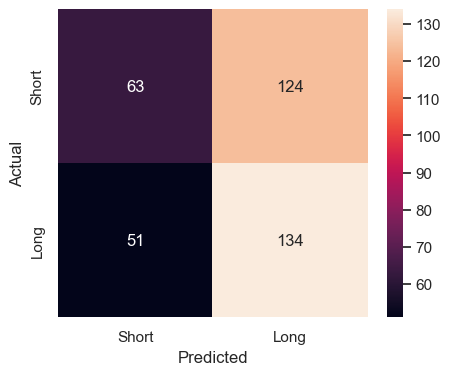

In [38]:
# Plotting the Confustion matrix
cm = confusion_matrix(y_test, y_pred)
df = pd.DataFrame(cm, index=['Short', 'Long'], columns=['Short', 'Long'])
plt.figure(figsize=(5, 4))
sns.heatmap(df, annot=True, fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [39]:
# Printing the classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.55      0.34      0.42       187
           1       0.52      0.72      0.60       185

    accuracy                           0.53       372
   macro avg       0.54      0.53      0.51       372
weighted avg       0.54      0.53      0.51       372

